# Model Comparison

This notebook compares the performance of all models trained for the **expected goals (xG)** task.  
The baseline model is **Linear Regression** (trained on DS3), while **Random Forest**, **XGBoost**, and **Neural Network (MLP)** are trained on DS4.  

The comparison focuses on the following aspects:

- **Quantitative metrics**: RMSE, MAE, R², Explained Variance, Pearson and Spearman correlation

- **Calibration analysis**: how well predicted probabilities align with observed outcomes

- **Overfitting check**: difference between training and test performance

- **Feature importance**: interpretation of influential features (where applicable)

This analysis allows to identify the best-performing model, evaluate calibration and generalization.

#### Imports and Global Settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display options
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# Paths
OUTPUT_DIR = "../task1_xg/outputs"
MODEL_DIR = "../task1_xg/models"

print("Setup complete. Ready to load metrics.")

Setup complete. Ready to load metrics.


#### Load Saved Metrics

In [2]:
# Load metrics saved from individual model notebooks
lin_metrics = pd.read_csv(f"{OUTPUT_DIR}/metrics_linear_regression.csv", index_col=0)
rf_metrics  = pd.read_csv(f"{OUTPUT_DIR}/metrics_rf.csv", index_col=0)
xgb_metrics = pd.read_csv(f"{OUTPUT_DIR}/metrics_xgboost.csv", index_col=0) 
nn_metrics   = pd.read_csv(f"{OUTPUT_DIR}/metrics_nn.csv", index_col=0)  # to add after NN is trained

# Concatenate all results
all_metrics = pd.concat([lin_metrics, rf_metrics, xgb_metrics, nn_metrics], axis=0)

all_metrics

,RMSE,MAE,R2,Pearson,Spearman
Linear Regression (train),0.0643,0.0393,0.7456,0.8643,0.8527
Linear Regression (test),0.0663,0.0403,0.7432,0.8632,0.8587
Random Forest (train),0.0146,0.0072,0.9869,0.9938,0.9949
Random Forest (test),0.0402,0.0199,0.9055,0.9517,0.9696
XGBoost (train),0.0274,0.0148,0.9537,0.9771,0.9754
XGBoost (test),0.0394,0.0193,0.9093,0.9542,0.9715
Neural Network (train),0.0368,0.0199,0.9165,0.9574,0.9566
Neural Network (test),0.0427,0.0217,0.8936,0.9456,0.9554


#### Overfitting Check

In [3]:
import pandas as pd

# Reset index so we can split Model and Dataset
all_metrics = all_metrics.reset_index().rename(columns={"index": "ModelSet"})

# Split "Model (train/test)" into "Model" and "Set"
all_metrics["Set"] = all_metrics["ModelSet"].apply(lambda x: "train" if "train" in x else "test")
all_metrics["Model"] = all_metrics["ModelSet"].apply(lambda x: x.replace(" (train)", "").replace(" (test)", ""))

all_metrics = all_metrics.drop(columns=["ModelSet"])

# Pivot: each model has train/test side by side
metrics_pivot = all_metrics.pivot_table(
    index="Model",
    columns="Set",
    values=["RMSE", "MAE", "R2", "Pearson", "Spearman"]
)

# Compute differences: Δ = Test - Train
delta_df = pd.DataFrame()
for metric in ["RMSE", "MAE", "R2", "Pearson", "Spearman"]:
    delta_df["Δ" + metric] = (
        metrics_pivot[metric]["test"] - metrics_pivot[metric]["train"]
    )

print("\nOverfitting check (Δ = Test - Train):")
display(delta_df)


Overfitting check (Δ = Test - Train):


,ΔRMSE,ΔMAE,ΔR2,ΔPearson,ΔSpearman
Model,,,,,
Linear Regression,0.0020,0.0010,-0.0024,-0.0011,0.0061
Neural Network,0.0058,0.0018,-0.0229,-0.0119,-0.0012
Random Forest,0.0256,0.0127,-0.0814,-0.0420,-0.0254
XGBoost,0.0120,0.0046,-0.0444,-0.0228,-0.0039


#### Compare Metrics

In [4]:
# Sort by RMSE
all_metrics_sorted = all_metrics.sort_values(by="RMSE")
display(all_metrics_sorted)

,RMSE,MAE,R2,Pearson,Spearman,Set,Model
2,0.0146,0.0072,0.9869,0.9938,0.9949,train,Random Forest
4,0.0274,0.0148,0.9537,0.9771,0.9754,train,XGBoost
6,0.0368,0.0199,0.9165,0.9574,0.9566,train,Neural Network
5,0.0394,0.0193,0.9093,0.9542,0.9715,test,XGBoost
3,0.0402,0.0199,0.9055,0.9517,0.9696,test,Random Forest
7,0.0427,0.0217,0.8936,0.9456,0.9554,test,Neural Network
0,0.0643,0.0393,0.7456,0.8643,0.8527,train,Linear Regression
1,0.0663,0.0403,0.7432,0.8632,0.8587,test,Linear Regression


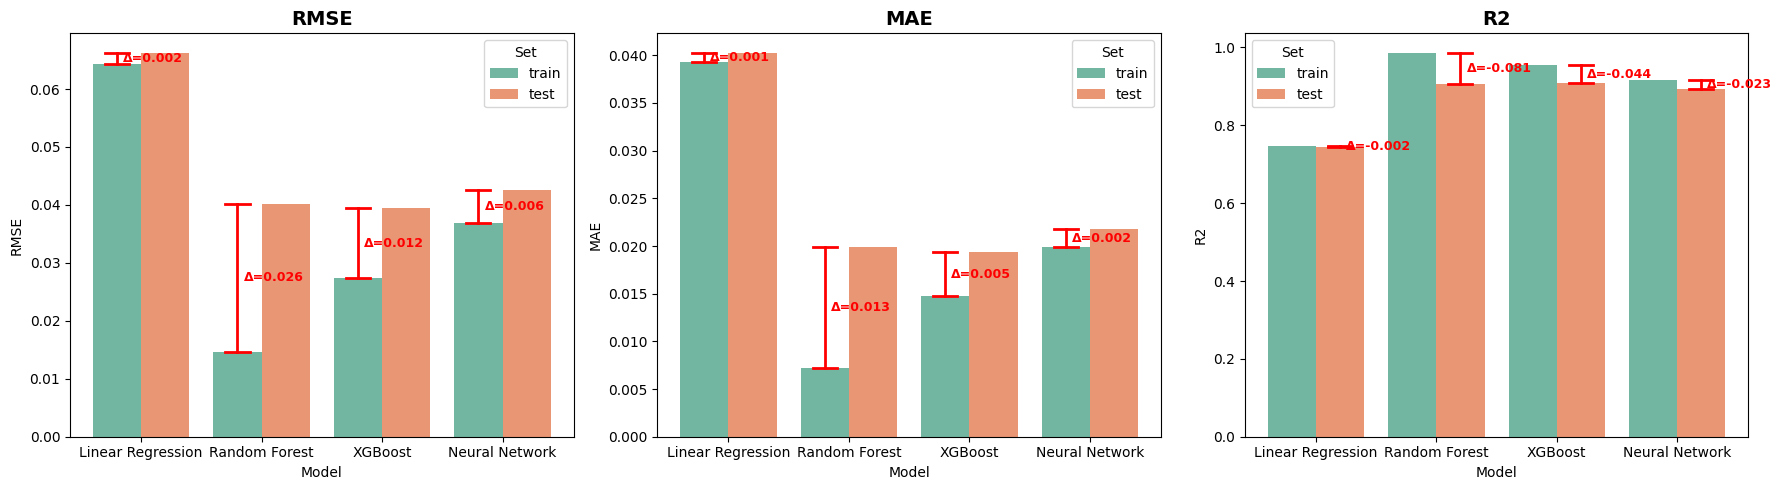

In [5]:
# List of metrics to plot
metrics = ["RMSE", "MAE", "R2"]

# Create figure with subplots
fig, axes = plt.subplots(1, len(metrics), figsize=(18, 5), sharey=False)

bar_width = 0.8                     # default seaborn bar width
n_hue = 2                           # train/test
bar_offset = bar_width / n_hue / 2  # half offset for hue

for i, metric in enumerate(metrics):

    # Create bar plot
    sns.barplot(
        data=all_metrics,
        x="Model",
        y=metric,
        hue="Set",
        palette="Set2",
        ax=axes[i]
    )

    # Customize plot
    axes[i].set_title(f"{metric}", fontsize=14, fontweight="bold")
    axes[i].set_xlabel("Model")
    axes[i].set_ylabel(metric)
    axes[i].legend(title="Set")

    # Add delta annotations
    for idx, model in enumerate(all_metrics["Model"].unique()):
        if f"Δ{metric}" in delta_df.columns:
            delta_val = delta_df.loc[model, f"Δ{metric}"]

            # Get y values of train and test bars to get the lowest
            vals = all_metrics.loc[all_metrics["Model"] == model, metric].values
            if len(vals) == 2:
                y_train, y_test = vals

                # True x positions of the bars
                x_train = idx - bar_offset
                x_test = idx + bar_offset

                # Decide which bar is lower (reference point for delta annotation)
                if y_train < y_test:
                    x_ref, y_min, y_max = x_train, y_train, y_test
                else:
                    x_ref, y_min, y_max = x_test, y_test, y_train

                # Draw vertical red line above the lower bar
                axes[i].plot(
                    [x_ref, x_ref],
                    [y_min, y_max],
                    color="red", linestyle="-", linewidth=2
                )

                # Horizontal caps at start and end
                axes[i].plot([x_ref - 0.1, x_ref + 0.1], [y_min, y_min], color="red", linewidth=2)
                axes[i].plot([x_ref - 0.1, x_ref + 0.1], [y_max, y_max], color="red", linewidth=2)

                # Annotate delta next to the line
                axes[i].text(
                    x_ref + 0.05, (y_min + y_max) / 2,   # small offset to the right
                    f"Δ={delta_val:.3f}",
                    ha="left", va="center",
                    fontsize=9, fontweight="bold", color="red"
                )

plt.tight_layout()
plt.show()


#### Calibration Analysis

Calibration curves are particularly important in the context of **expected goals (xG)**, since the output of the model is interpreted directly as the probability of scoring.  

Before analyzing calibration, the **distribution of `target_xg`** is inspected. The percentiles show that the vast majority of shots have very low xG, while high-probability shots are rare events. This imbalance explains why calibration curves typically align well in the low range and diverge in the upper bins: the model has limited training data for rare high-xG events, making those predictions harder to calibrate.


In [ ]:
from sklearn.model_selection import train_test_split

# Load datasets
ds3 = pd.read_csv(f"../task1_xg/data/DS3.csv")
ds4 = pd.read_csv(f"../task1_xg/data/DS4.csv")

# Drop ID columns since they are not needed for modeling
ds3 = ds3.drop(columns=['event_id', 'match_id', 'player_id'])
ds4 = ds4.drop(columns=['event_id', 'match_id', 'player_id'])

# Define features and target
target_column = "target_xg"  # expected goals column
train_columns_ds3 = [col for col in ds3.columns if col != target_column]
train_columns_ds4 = [col for col in ds4.columns if col != target_column]

# Define features and target for both datasets
X_ds3 = ds3[train_columns_ds3]
y_ds3 = ds3[target_column]

X_ds4 = ds4[train_columns_ds4]
y_ds4 = ds4[target_column]

# Split into train and test sets
X_train_ds3, X_test_ds3, y_train_ds3, y_test_ds3 = train_test_split(
    X_ds3, y_ds3, test_size=0.2, random_state=RANDOM_STATE
)

X_train_ds4, X_test_ds4, y_train_ds4, y_test_ds4 = train_test_split(
    X_ds4, y_ds4, test_size=0.2, random_state=RANDOM_STATE
)

print("DS3:")
print(f"Dataset: {X_ds3.shape[0]} rows, {X_ds3.shape[1]} features")
print(f"Training set: {X_train_ds3.shape[0]} rows")
print(f"Test set: {X_test_ds3.shape[0]} rows")

print("\nDS4:")
print(f"Dataset: {X_ds4.shape[0]} rows, {X_ds4.shape[1]} features")
print(f"Training set: {X_train_ds4.shape[0]} rows")
print(f"Test set: {X_test_ds4.shape[0]} rows")


DS3:
Dataset: 86833 rows, 42 features
Training set: 69466 rows
Test set: 17367 rows

DS4:
Dataset: 86833 rows, 25 features
Training set: 69466 rows
Test set: 17367 rows


Distribution of target_xg (percentiles + counts):

Percentile  Value  Rows
        1% 0.0059   869
        5% 0.0085  4342
       10% 0.0140  8684
       25% 0.0275 21709
       50% 0.0540 43417
       75% 0.1060 65125
       90% 0.2310 78149
       95% 0.3617 82491
       99% 0.6884 85964


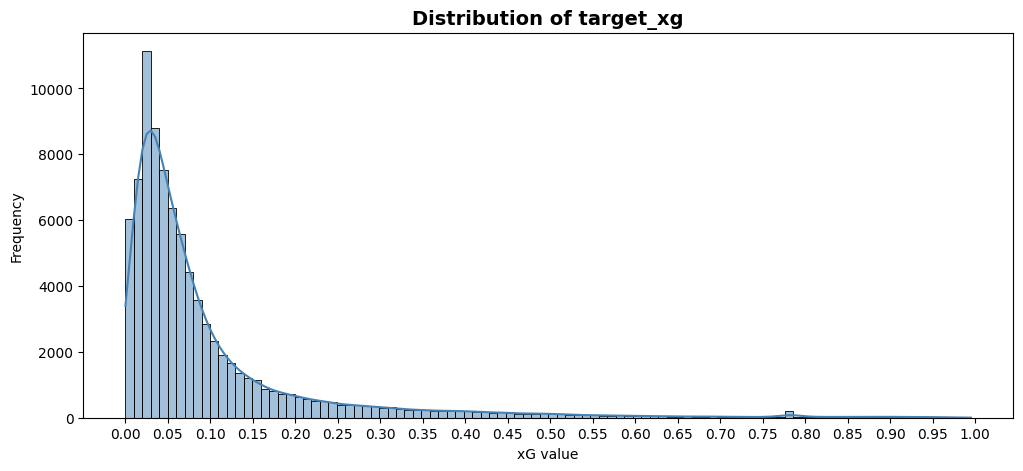

In [7]:
# Distribution analysis of target_xg

# Compute percentiles
percentiles_list = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
percentile_values = np.percentile(y_ds3, [p * 100 for p in percentiles_list])

# Build DataFrame with percentile, value, and counts
rows = []
for p, val in zip(percentiles_list, percentile_values):
    count = (y_ds3 <= val).sum()
    rows.append({
        "Percentile": f"{int(p*100)}%",
        "Value": round(val, 4),
        "Rows": count
    })

df_percentiles = pd.DataFrame(rows)

print("Distribution of target_xg (percentiles + counts):\n")
print(df_percentiles.to_string(index=False))

plt.figure(figsize=(12,5))
sns.histplot(y_ds3, bins=100, kde=True, color="steelblue")
plt.title("Distribution of target_xg", fontsize=14, fontweight="bold")
plt.xticks(np.arange(0, y_ds3.max() + 0.05, 0.05))
plt.xlabel("xG value")
plt.ylabel("Frequency")
plt.show()

In [ ]:
import joblib
import numpy as np

# Load models
lin_reg = joblib.load(f"{MODEL_DIR}/model_linear_regression.pkl")
rf_model = joblib.load(f"{MODEL_DIR}/model_rf.pkl")
xgb_model = joblib.load(f"{MODEL_DIR}/model_xgboost.pkl")
nn_model  = joblib.load(f"{MODEL_DIR}/model_nn.pkl") 

# Predictions
# DS3 for linear regression clip because it can output values outside [0, 1]
y_lin_pred = np.clip(lin_reg.predict(X_test_ds3), 0, 1)

# DS4 for RF, XGB, NN
y_rf_pred  = rf_model.predict(X_test_ds4)
y_xgb_pred = xgb_model.predict(X_test_ds4)
y_nn_pred  = nn_model.predict(X_test_ds4)

print("Predictions ready for calibration analysis")


Predictions ready for calibration analysis.


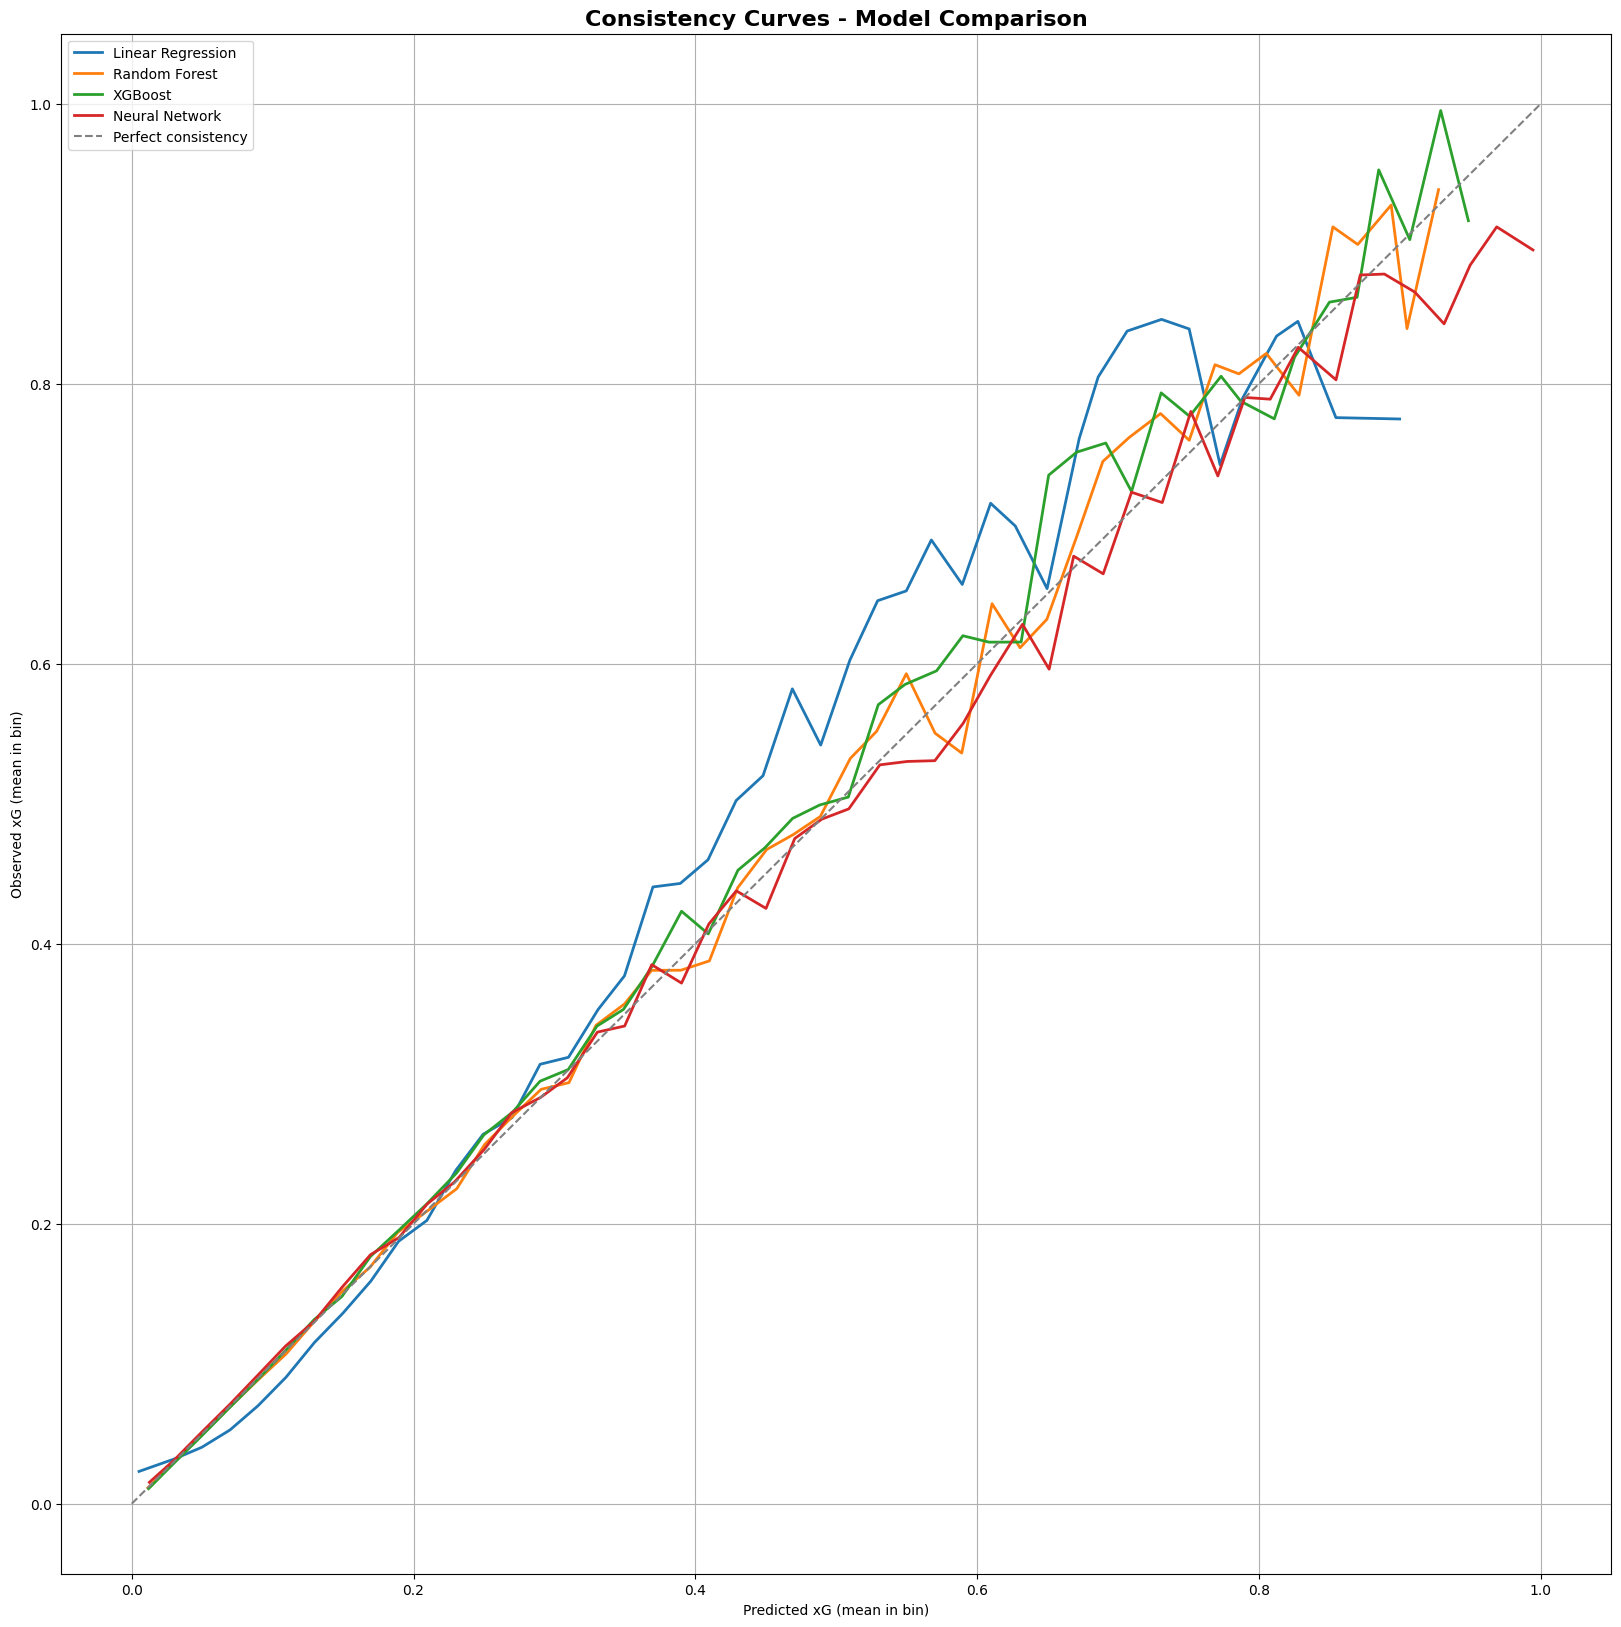

In [9]:
def plot_calibration_xg(y_true, y_pred, n_bins=50, label=None):
    """
    Consistency check between predicted xG (y_pred) and true xG (y_true)
    Since y_true is continuous [0,1], the average of y_true per prediction bin is computed
    """
    # Create equally spaced bins between 0 and 1
    bins = np.linspace(0, 1, n_bins + 1)            # bins: [0.0, 0.02, 0.04, ..., 1.0]
    bin_ids = np.digitize(y_pred, bins) - 1         # bin_ids: [0, 0, 1, 2, ..., n_bins-1]

    bin_true = []
    bin_pred = []

    for i in range(n_bins):
        mask = bin_ids == i
        if np.any(mask):

            # Average of predicted values in the bin
            bin_pred.append(y_pred[mask].mean())
            
            # Average of true xG values in the bin
            bin_true.append(y_true[mask].mean())

    # Plot curve
    plt.plot(bin_pred, bin_true, label=label, linewidth=2)

plt.figure(figsize=(20,20))

plot_calibration_xg(y_test_ds3, y_lin_pred, label="Linear Regression")
plot_calibration_xg(y_test_ds4, y_rf_pred,  label="Random Forest")
plot_calibration_xg(y_test_ds4, y_xgb_pred, label="XGBoost")
plot_calibration_xg(y_test_ds4, y_nn_pred,  label="Neural Network")

# Reference line = perfect consistency
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect consistency")

plt.xlabel("Predicted xG (mean in bin)")
plt.ylabel("Observed xG (mean in bin)")
plt.title("Consistency Curves - Model Comparison", fontsize=16, fontweight="bold")
plt.legend()
plt.grid(True)
plt.show()


## Conclusion

The comparison across models highlights a clear trade-off between **simplicity**, **predictive accuracy**, and **generalization ability** 

- **Linear Regression** performs worst in absolute terms, with RMSE ≈ 0.07 and R² ≈ 0.72 on the test set. However, it shows **minimal overfitting**, as the gap between training and test metrics is very small. This indicates that the model is stable but limited in its ability to capture complex, non-linear patterns

- **Random Forest** achieves the lowest error on the training set (RMSE ≈ 0.015, R² ≈ 0.99), but this comes at the cost of **significant overfitting**, as performance drops on the test set (RMSE ≈ 0.040, R² ≈ 0.91). The large Δ between train and test confirms that Random Forest tends to memorize the data rather than generalize

- **XGBoost** represents the best overall compromise. With RMSE ≈ 0.027 (train) and 0.039 (test), and R² around 0.91 on the test set, it achieves strong predictive accuracy while maintaining a relatively small generalization gap (ΔRMSE ≈ 0.012). This demonstrates that XGBoost can model non-linear relationships effectively while avoiding excessive overfitting

- **Neural Network** achieves test performance close to XGBoost (RMSE ≈ 0.043, R² ≈ 0.89), but with slightly larger generalization loss. While more flexible, the NN shows higher variance and is more sensitive to training conditions, which can explain its lower stability compared to XGBoost

Overall, the **distribution of xG values** (highly skewed toward small probabilities) makes the task challenging, as models must be precise in the low-probability region while still capturing rare high-xG events. In this context, **XGBoost emerges as the most balanced solution**, offering strong accuracy, robustness, and good calibration, while Random Forest is powerful but prone to overfitting, and Linear Regression serves mainly as a stable but limited baseline